In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "8g")\
    .getOrCreate()

spark

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit

from common import *

pd.set_option('display.max_rows', 100)

# Forwarder-Sequencer Latency

In [15]:
PREFIX = 'main/tpcc/ddr_ts-clients50'
SERVER = '7-0'

forw_sequ_latency_schema = StructType([
    StructField("dst", T.IntegerType(), False),
    StructField("send_time", T.DoubleType(), False),
    StructField("recv_time", T.DoubleType(), False),
    StructField("avg_latency", T.DoubleType(), False),
])

fs_latency_df = spark.read.csv(
    f"{PREFIX}/server/{SERVER}/forw_sequ_latency.csv",
    header=True,
    schema=forw_sequ_latency_schema
).toPandas()
fs_latency_df.index = normalize2(fs_latency_df["send_time"])
fs_latency_df.loc[:, "avg_latency"] = fs_latency_df["avg_latency"] / 1000000

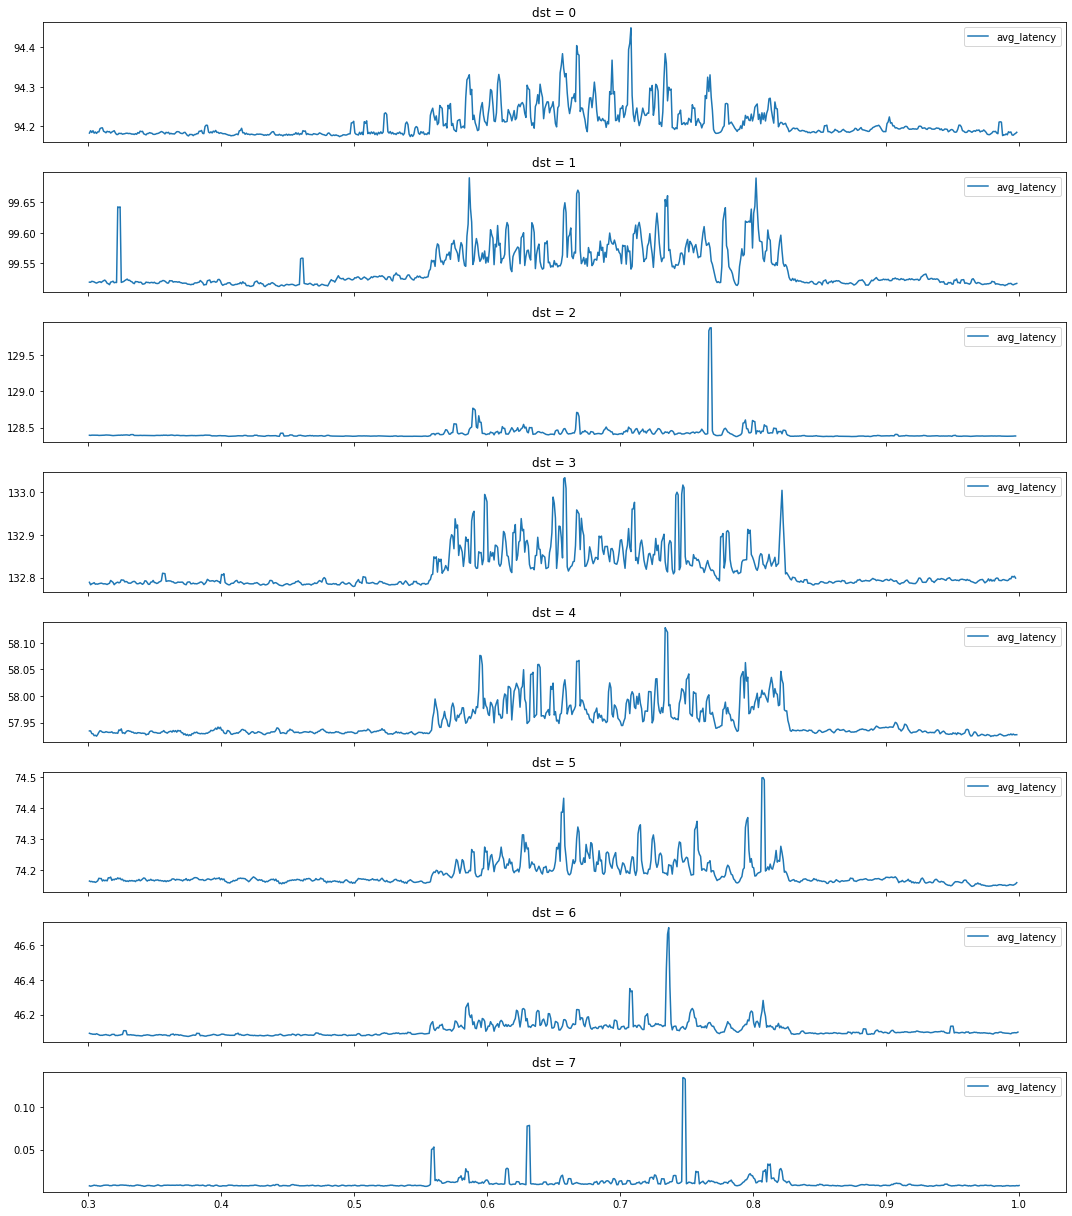

In [16]:
dst = sorted(fs_latency_df["dst"].unique())
_, axes = plt.subplots(len(dst), 1, figsize=(15, 17), sharex=True)

for i, d in enumerate(dst):
    fs_latency_df.loc[(fs_latency_df.dst == d) & (fs_latency_df.index > 0.3)].plot(
        y="avg_latency",
        ax=axes[i]
    )
    axes[i].set_title(f"dst = {d}")

plt.tight_layout()

# Clock Synchronization

In [21]:
PREFIX = 'main/tpcc/ddr_ts-clients50'
SERVER = '0-0'

clock_sync_schema = StructType([
    StructField("dst", T.IntegerType(), False),
    StructField("src_send_time", T.DoubleType(), False),
    StructField("dst_send_time", T.DoubleType(), False),
    StructField("src_recv_time", T.DoubleType(), False),
    StructField("local_slog_time", T.DoubleType(), False),
    StructField("avg_latency", T.DoubleType(), False),
    StructField("new_offset", T.DoubleType(), False),
])

clock_sync_df = spark.read.csv(
    f"{PREFIX}/server/{SERVER}/clock_sync.csv",
    header=True,
    schema=clock_sync_schema
).toPandas()
clock_sync_df.index = normalize2(clock_sync_df["src_recv_time"])
clock_sync_df.sort_index(inplace=True)
clock_sync_df.loc[:, "avg_latency"] = clock_sync_df["avg_latency"] / 1000000
clock_sync_df.loc[:, "new_offset"] = clock_sync_df["new_offset"] / 1000000

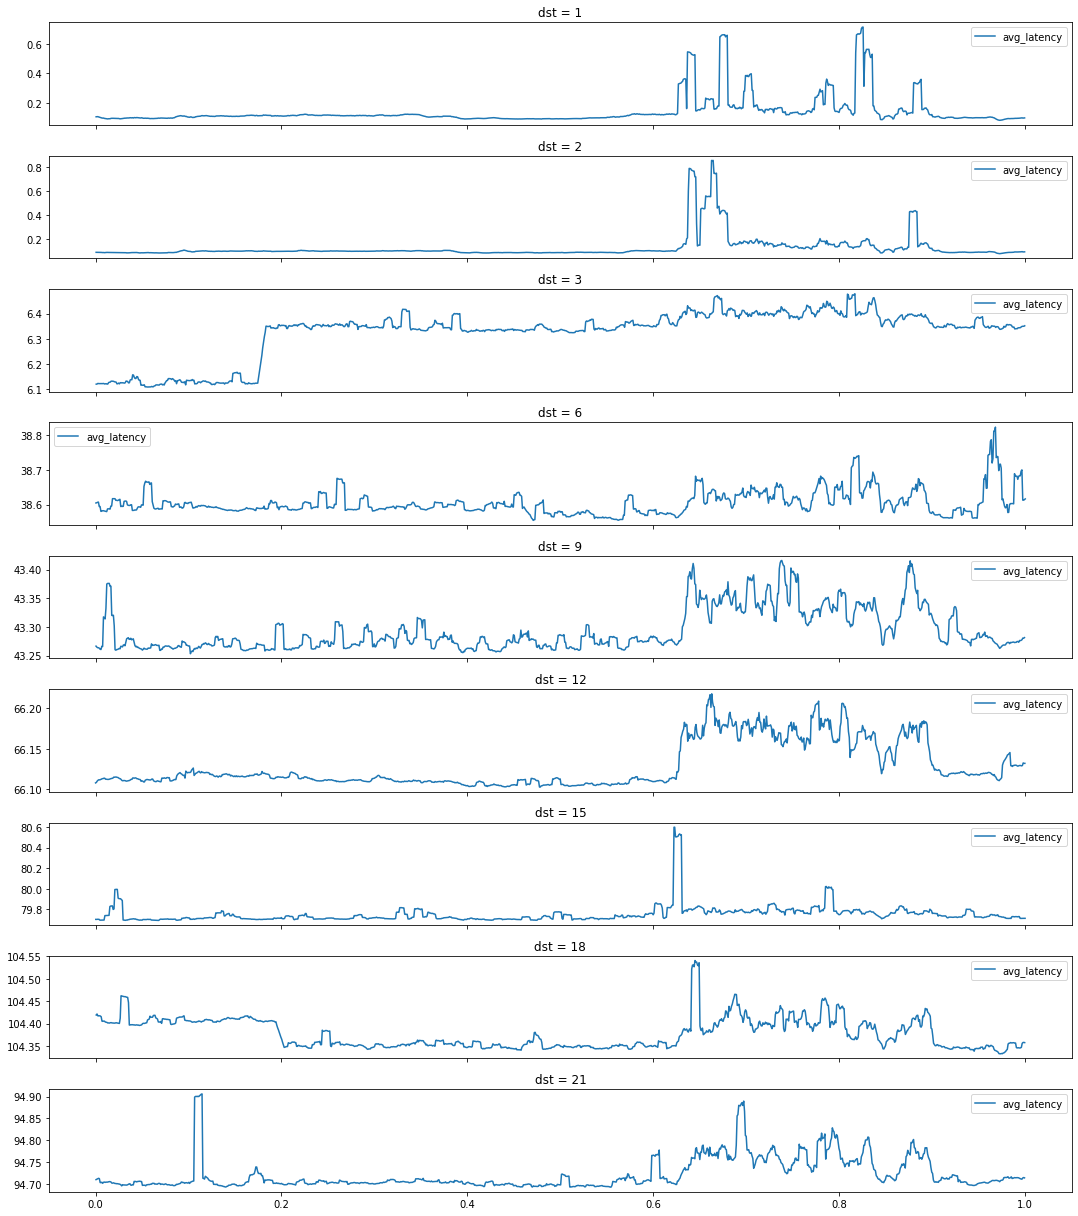

In [22]:
dst = sorted(clock_sync_df["dst"].unique())
_, axes = plt.subplots(len(dst), 1, figsize=(15, 17), sharex=True)

for i, d in enumerate(dst):
    clock_sync_df.loc[(clock_sync_df.dst == d)].plot(
        y="avg_latency",
        ax=axes[i]
    )
    axes[i].set_title(f"dst = {d}")

plt.tight_layout()

<AxesSubplot:>

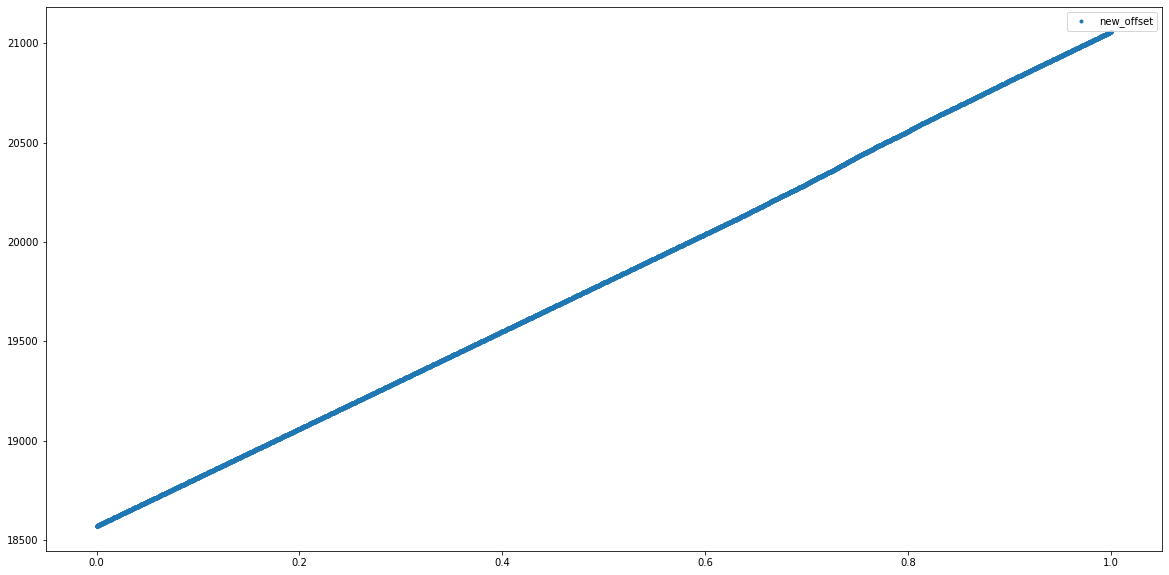

In [23]:
clock_sync_df.plot(y="new_offset", figsize=(20, 10), marker='.', linewidth=0)
    

# Global Log Position

In [47]:
PREFIX = 'main/tpcc/ddr_ts-clients112'

txn_sdf = transactions_csv(spark, PREFIX)\
    .select(
        "txn_id",
        "coordinator",
        "replicas",
        "partitions",
        "global_log_pos",
        "machine",
        (F.array_max("global_log_pos") - F.array_min("global_log_pos")).alias("global_log_dist"),
        ((col("received_at") - col("sent_at"))/1000000).alias("latency"))\
    .where(F.size("replicas") > 1)

txn_df = txn_sdf.toPandas()
txn_df

,txn_id,coordinator,replicas,partitions,global_log_pos,machine,global_log_dist,latency
0,5246704,4,"[0, 1]",[2],"[388888, 388992]",1,104,25.034240
1,5507604,4,"[1, 2]",[2],"[416331, 416840]",1,509,80.419328
2,7475404,4,"[0, 1]",[2],"[615907, 616011]",1,104,23.763712
3,6864705,5,"[0, 1]",[2],"[560821, 560887]",1,66,17.921024
4,6264604,4,"[0, 1]",[1],"[500839, 501006]",1,167,28.856832
...,...,...,...,...,...,...,...,...
5100,10628802,2,"[0, 6]",[2],"[593138, 594389]",0,1251,222.702080
5101,4860202,2,"[0, 7]",[0],"[328509, 329791]",0,1282,195.013120
5102,10592900,0,"[0, 1]",[1],"[591210, 591294]",0,84,23.203840
5103,6351901,1,"[0, 1]",[2],"[405002, 405034]",0,32,23.102720


<AxesSubplot:xlabel='global_log_dist', ylabel='latency'>

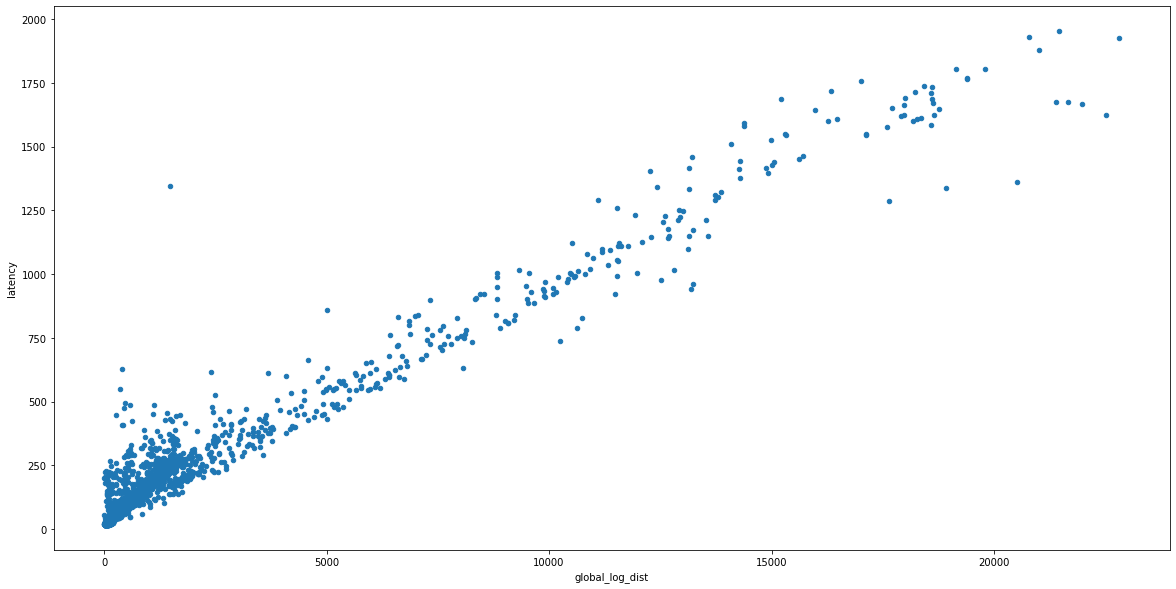

In [48]:
txn_df.plot.scatter(x="global_log_dist", y="latency", figsize=(20, 10))

In [46]:
txn_df[(txn_df.latency > 1000) & (txn_df.global_log_dist < 2000)]

,txn_id,coordinator,replicas,partitions,global_log_pos,machine,global_log_dist,latency
152,3601505,5,"[1, 4]",[0],"[265561, 265726]",1,165,1029.313536
713,2094918,18,"[6, 7]",[2],"[269948, 270430]",6,482,1066.710528
874,2076119,19,"[2, 6]",[0],"[264936, 265718]",6,782,1300.985344
941,44309,9,"[2, 3]",[2],"[1153, 1172]",3,19,1486.188800
945,3320909,9,"[3, 7]",[0],"[264101, 265329]",3,1228,1154.475264
991,77510,10,"[0, 3]",[2],"[3220, 3479]",3,259,1387.244800
1770,3219816,16,"[3, 5]",[2],"[270146, 271021]",5,875,1245.242368
2045,3566914,14,"[4, 6]",[1],"[266391, 266876]",4,485,1006.329088
2119,3567412,12,"[2, 4]",[1],"[266958, 267063]",4,105,1011.978240
2442,3550614,14,"[4, 7]",[0],"[264263, 265149]",4,886,1056.947456
